<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>



In [25]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em orgem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10403025, Gabriel Gonzaga Chung' #@param {type:"string"}
Aluno2 = '10403462, Igor Benites Moura' #@param {type:"string"}
Aluno3 = ' 10401873, Rodrigo Machado de Assis Oliveira de Lima' #@param {type:"string"}
Aluno4 = 'None' #@param {type:"string"}
Aluno5 = 'None' #@param {type:"string"}



In [6]:
#@title Assinale aqui a sua opção de Projeto
Projeto = "IA Aplicada a Imagens: Uso de Modelos de Redes Neurais" #@param ["IA Aplicada a Imagens: Uso de Modelos de Redes Neurais", "IA Aplicada a Documentos: Uso de Grandes Modelos de Linguagem Abertos"]




# **Resumo**

Apresente um "abstract" do seu projeto.

1. Objetivo do projeto
2. Fontes dos dados e dados originais (coletados)
3. Ferramentas/pacotes de IA a serem utilizados para a construção da solução
4. Um prévia dos resultados.

<p align="justify"> O objetivo deste projeto é desenvolver um sistema capaz de classificar expressões faciais humanas em quatro categorias emocionais básicas: raiva, felicidade, tristeza e surpresa. Para isso, foi construída e treinada uma rede neural convolucional (CNN) utilizando imagens faciais em tons de cinza com resolução de 48x48 pixels. Os dados utilizados foram oriundos de fontes públicas como FER-2013 de M. Sambare e  e de coletas próprias, sendo organizados em diretórios por classe. As imagens passaram por técnicas de data augmentation para aumentar a variabilidade e robustez do treinamento. A solução foi implementada com auxílio das bibliotecas TensorFlow, Keras e NumPy, e a aplicação final foi integrada a uma interface interativa desenvolvida em Streamlit, permitindo que usuários submetam imagens e obtenham a predição da emoção predominante. Como resultado, o modelo alcançou uma acurácia de aproximadamente 74% na base de validação, demonstrando bom desempenho na tarefa de reconhecimento facial de emoções

# **Apresentação dos dados**

<div align="justify">

O conjunto de dados utilizado no projeto é composto por imagens de expressões faciais organizadas em quatro classes principais: `angry` (raiva), `happy` (feliz), `sad` (triste) e `surprise` (surpresa). As imagens foram utilizadas no formato em **tons de cinza** com **resolução 48x48 pixels**, visando compatibilidade com a arquitetura da CNN e menor custo computacional.

As imagens foram coletadas a partir do dataset **FER-2013**, **affectnet** e complementadas com coletas próprias. Todas as imagens foram organizadas em pastas no formato esperado por `ImageDataGenerator` da biblioteca Keras, seguindo a estrutura:



### Link de referência:
- FER-2013: [https://www.kaggle.com/datasets/msambare/fer2013](https://www.kaggle.com/datasets/msambare/fer2013)
- affectnet: [https://www.kaggle.com/datasets/mstjebashazida/affectnet](https://www.kaggle.com/datasets/mstjebashazida/affectnet)

---

### Exemplos de amostras:

| Angry | Happy | Sad | Surprise |
|-------|-------|-----|----------|
| ![angry](data/test/angry/PrivateTest_4129990.jpg) | ![happy](data/test/happy/PublicTest_97661985.jpg) | ![sad](data/test/sad/PrivateTest_552501.jpg) | ![surprise](data/test/surprise/PrivateTest_1673508.jpg) |

*(Imagens ilustrativas)*

---

### Distribuição dos dados (treinamento):

| Classe     | Quantidade |
|------------|------------|
| Happy      | 9555       |
| Sad        | 7921       |
| Angry      | 5495       |
| Surprise   | 5290       |
| **Total**  | **28.261** |

O dataset apresenta certo desbalanceamento, que foi corrigido no treinamento por meio da atribuição de **pesos por classe** com base na proporção de dados.

</div>

# Abaixo algumas seções de exemplo

> Pode haver mais, dependendo da sua aplicação. Para cada seção faça comentários explicando a tarefa e comentando/sumarizando os resultados.

# **Importações de Pacotes**

Foram importados os pacotes necessários para a criação do modelo, neste caso: \
\
**Tensorflow**: Framework de aprendizado de máquina. \
**Keras**: API de alto nível para construir e treinar modelos. \
**Numpy**: Computação numérica eficiente com arrays.\
**Matplotlib**: Criação de gráficos para visualização.\
**Pandas**: Uma ferramenta de análise e manipulação de dados de código aberto, rápida, poderosa, flexível e fácil de usar. \
**Scikit-learn**: Ferramentas simples e eficientes para análise preditiva de dados.

In [7]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Configuração de GPU**

Testa para ver se alguma **GPU** foi identificada, se sim configura crescimento de memória.

In [9]:
# === GPU Configuration ===
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# **Preparação e transformação dos dados**



Nesta etapa, as imagens faciais foram organizadas em pastas separadas por classe (`angry`, `happy`, `sad`, `surprise`).


In [10]:
# === Classes ===
classes_usadas = ['angry', 'happy', 'sad', 'surprise']

Foram definidos os diretórios das dados de **treino** e **validação**.

In [11]:
# === Diretórios ===
train_dir = 'data/train'
val_dir = 'data/test'

Foi definido pesos para cada classe (**class weight**), visto que os dados estão desbalanceados entre cada classe <br> (tem mais dados de **"happy"** que **"surprise"**, por exemplo).

In [12]:
# === Class Weights ===
n_classes = len(classes_usadas)
n_data = [0] * n_classes
n_data[0] = 5495 # angry
n_data[1] = 9555 # happy
n_data[2] = 7921 # sad
n_data[3] = 5290 # surprise

total_data = sum(n_data)
class_weights = {
    i: total_data / (n_data[i] * n_classes) for i in range(n_classes)
}

Foi aplicado **data augmentation** com operações como rotação, zoom, translação e espelhamento horizontal para **aumentar a variabilidade** do conjunto de treinamento e **reduzir o overfitting**. Além disso, foram calculados **pesos por classe** com base no número de exemplos por emoção, equilibrando o aprendizado da rede em um cenário desbalanceado.

In [13]:
# === Data Augmentation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

As imagens foram utilizadas em tons de cinza com dimensão de **48x48 pixels**.


In [14]:
# === Dados de Treino ===
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    classes=classes_usadas,
    batch_size=64,
    shuffle=True
)

# === Dados de Validação ===
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    classes=classes_usadas,
    batch_size=64,
    shuffle=False
)

Found 28261 images belonging to 4 classes.
Found 4810 images belonging to 4 classes.


### Resumo dos dados:

| Classe     | Quantidade |
|------------|------------|
| Happy      | 9555       |
| Sad        | 7921       |
| Angry      | 5495       |
| Surprise   | 5290       |
| **Total**  | **28.261** |

# **Modelo Implementado**

Implementação do Modelo de rede convolucional do Keras.

In [15]:

# === Modelo CNN ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.15),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax')
])

# **Fine Tuning do modelo**

Foram testadas diferentes quantidades de filtros, camadas `Dropout`, e ajustes na função de ativação, tamanho dos kernels e taxa de aprendizado. O modelo final foi composto por **quatro blocos convolucionais com BatchNormalization, MaxPooling e Dropout**, seguido por camadas densas e softmax na saída.

Além disso, foi utilizado:
- `EarlyStopping`: para interromper o treino ao detectar estagnação.
- `ModelCheckpoint`: para salvar automaticamente o melhor modelo com base na acurácia de validação.
- `Adam` com **learning rate ajustado (0.0005)** para convergência mais estável.

In [16]:
# === Compilação ===
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

# **Treinamento do Modelo**

In [17]:
# === Treinamento ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weights
)

Epoch 1/100
442/442 [==============================] - 161s 357ms/step - loss: 1.4724 - accuracy: 0.3150 - val_loss: 1.5717 - val_accuracy: 0.2886
Epoch 2/100
442/442 [==============================] - 17s 39ms/step - loss: 1.2772 - accuracy: 0.3958 - val_loss: 1.1843 - val_accuracy: 0.4530
Epoch 3/100
442/442 [==============================] - 17s 39ms/step - loss: 1.1831 - accuracy: 0.4646 - val_loss: 1.1386 - val_accuracy: 0.4981
Epoch 4/100
442/442 [==============================] - 17s 39ms/step - loss: 1.1064 - accuracy: 0.5058 - val_loss: 0.9796 - val_accuracy: 0.5775
Epoch 5/100
442/442 [==============================] - 17s 38ms/step - loss: 1.0465 - accuracy: 0.5431 - val_loss: 1.1255 - val_accuracy: 0.5119
Epoch 6/100
442/442 [==============================] - 17s 39ms/step - loss: 0.9989 - accuracy: 0.5731 - val_loss: 0.9749 - val_accuracy: 0.5996
Epoch 7/100
442/442 [==============================] - 17s 38ms/step - loss: 0.9563 - accuracy: 0.5972 - val_loss: 0.8559 - val_

In [18]:
# === Salvar Modelo ===
model.save("models/final_model.h5")

# **Avaliação do modelo**




<div align="justify">

Após o treinamento, o modelo foi avaliado no conjunto de validação. O resultado foi uma acurácia de aproximadamente **74,5%**, o que representa um desempenho bastante satisfatório, considerando a **ausência de técnicas de transfer learning**, a presença de **dados desbalanceados** entre as classes e a **complexidade natural da tarefa de classificação de emoções faciais**.

A **curva de acurácia** apresentou crescimento consistente ao longo das épocas, com a acurácia de validação acompanhando de perto a de treinamento, indicando **boa generalização** e **ausência de overfitting significativo**. Já o **gráfico da função de perda (loss)** mostrou uma redução progressiva da perda tanto no conjunto de treinamento quanto no de validação, com pequenas oscilações naturais em razão da variação nos batches. Essa tendência reforça que o modelo foi capaz de aprender os padrões relevantes nas imagens sem memorizar os dados.


</div>


76/76 [==============================] - 2s 30ms/step - loss: 0.6936 - accuracy: 0.7200
Acurácia em validação: 0.72


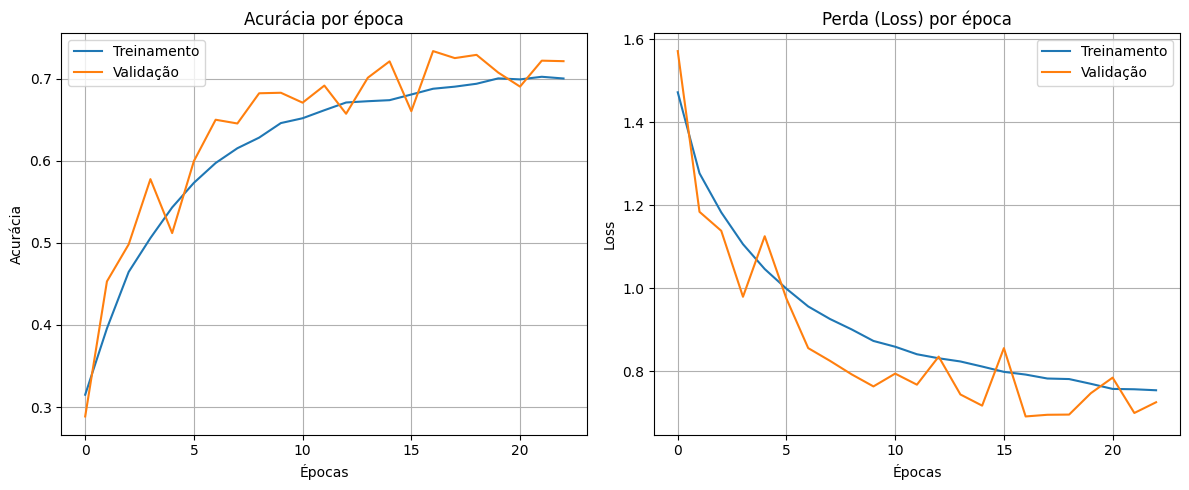

In [19]:
# === Avaliação final ===
loss, acc = model.evaluate(val_data)
print(f"Acurácia em validação: {acc:.2f}")

# === Gráficos de desempenho ===
plt.figure(figsize=(12, 5))

# Acurácia por época
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Perda por época
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss) por época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



A **matriz de confusão** revelou que o modelo possui um bom equilíbrio entre as classes, acertando corretamente a maioria das amostras. No entanto, observou-se uma tendência de confusão entre as emoções `sad` e `angry`, o que é esperado dada a similaridade visual de certas expressões faciais nessas categorias. Por outro lado, emoções mais distintas como `happy` e `surprise` apresentaram altas taxas de acerto, refletindo maior separabilidade entre suas representações visuais.

76/76 [==============================] - 2s 30ms/step


<Figure size 600x600 with 0 Axes>

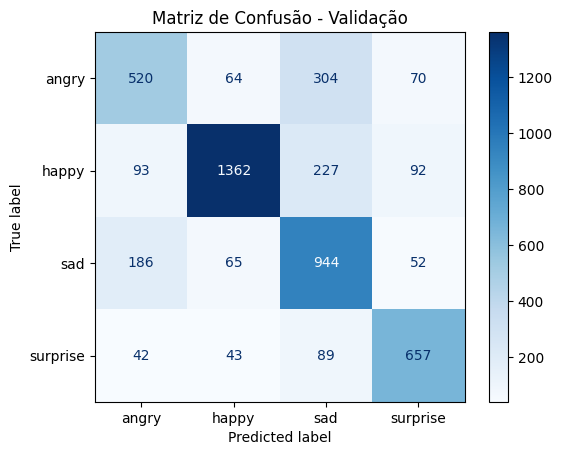

In [20]:
# === Matriz de Confusão ===

# Rótulos verdadeiros e previstos
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Geração e exibição da matriz
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_usadas)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão - Validação")
plt.grid(False)
plt.show()

Por fim, a **distribuição das previsões por classe** foi visualmente coerente quando testada em imagens reais, por meio da interface construída com Streamlit, demonstrando a aplicabilidade prática do modelo em um sistema interativo de reconhecimento emocional.

# **Consumo do modelo**

<p align="justify"> Para o consumo do modelo tivemos, subimos uma aplicação <strong>Streamlit</strong> que permite o usuário fornecer uma imagem, e quando apertado um botão chamado <em>"Classificar Emoção"</em>, são demonstrados a emoção reconhecida e uma distribuição de probabilidades.

**A aplicação está presente em:** https://face-recognit.streamlit.app/

# **Referências**

SAMBARE M. **FER-2013.** Disponível em: <https://www.kaggle.com/datasets/msambare/fer2013>. Acesso em: 28 maio 2025.

MST. JEBA SHAZIDA. AffectNet. Disponível em: <https://www.kaggle.com/datasets/mstjebashazida/affectnet>. Acesso em: 28 maio 2025.

KERAS. **Home - Keras Documentation**. Disponível em: <https://keras.io/>. Acesso em: 28 maio 2025.

OPENCV. **OpenCV documentation index.** Disponível em: <https://docs.opencv.org/>. Acesso em: 28 maio 2025.

TENSORFLOW. **TensorFlow.** Disponível em: <https://www.tensorflow.org/>. Acesso em: 28 maio 2025.

PANDAS. **Pandas.** Disponível em: <https://pandas.pydata.org/>. Acesso em: 28 maio 2025.

SCIKIT.**Scikit-learn.** Disponível em: <https://www.scikit-learn.org/>. Acesso em: 28 maio 2025.


---

In [21]:
#@title **Avaliação**
GitHub = 10 #@param {type:"slider", min:0, max:10, step:1}

Implementacao_Model_Code = 10 #@param {type:"slider", min:0, max:10, step:1}

Aplicacao_Streamlit = 10 #@param {type:"slider", min:0, max:10, step:1}

Texto_Artigo  = 10 #@param {type:"slider", min:0, max:10, step:1}

Video = 10 #@param {type:"slider", min:0, max:10, step:1}

Geral = 10 #@param {type:"slider", min:0, max:10, step:1}








In [26]:
#@title **Nota Final**

nota = 2*GitHub + 4*Implementacao_Model_Code + 2*Aplicacao_Streamlit + 1*Texto_Artigo + 1*Video

nota = nota / 10

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

Nota final do trabalho 10.0



,tia,nome,nota
0,10403025,GABRIEL GONZAGA CHUNG,10.0
1,10403462,IGOR BENITES MOURA,10.0
2,10401873,RODRIGO MACHADO DE ASSIS OLIVEIRA DE LIMA,10.0
